In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [4]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [6]:
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [8]:
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [10]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [12]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [14]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [16]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [18]:
match_df = match_df[match_df['dl_applied'] == 0]
match_df = match_df[['match_id','city','winner','total_runs']]
delivery_df = match_df.merge(delivery,on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [22]:
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')
delivery_df['total_runs_y'].fillna(0, inplace=True)
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball']

C:\Users\Ridhwit\AppData\Local\Temp\ipykernel_10896\1541694793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  delivery_df['total_runs_y'].fillna(0, inplace=True)


In [30]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(
    lambda x: 0 if str(x).strip() == "0" else 1
)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(int)
delivery_df['cumulative_wickets'] = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - delivery_df['cumulative_wickets']

In [32]:
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result,axis=1)
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]
final_df = final_df.sample(final_df.shape[0])

In [34]:
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [38]:
trf = ColumnTransformer(
    transformers=[
        ('trf', OneHotEncoder(sparse_output=False, drop='first'), 
         ['batting_team', 'bowling_team', 'city'])
    ],
    remainder='passthrough' 
)
transformed_data = trf.fit_transform(delivery_df)

In [40]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [42]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test,y_pred)

0.8064335272268555

In [44]:
pipe.predict_proba(X_test)[10]

array([0.70227867, 0.29772133])

In [48]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))
    

In [50]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

In [54]:
temp_df,target = match_progression(delivery_df,74,pipe)

Target- 178


Text(0.5, 1.0, 'Target-178')

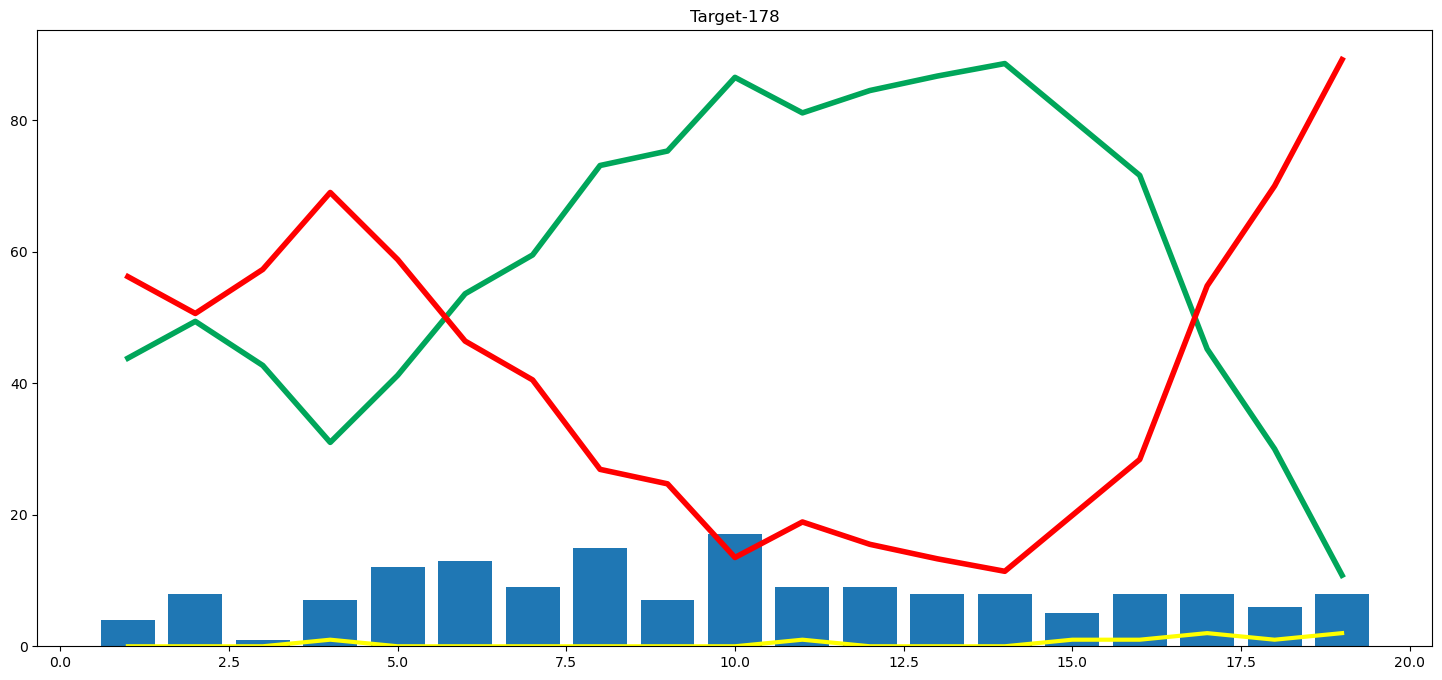

In [56]:
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [58]:
pickle.dump(pipe,open('pipe.pkl','wb'))